In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial

%matplotlib inline

In [2]:
astrocytes_pos = np.load("../InputData/CellPositions/astrocyte_positions.npy", 
                         allow_pickle=True, 
                         encoding='bytes')
neurons_pos = np.load("../InputData/CellPositions/neuronal_positions_v6_astro_bbox.npy", 
                      allow_pickle=True, 
                      encoding='bytes')

astro_x, astro_y, astro_z = astrocytes_pos.T
neuro_x, neuro_y, neuro_z = neurons_pos.T
n_astro = len(astrocytes_pos)
n_neuro = len(neurons_pos)

## Data Review

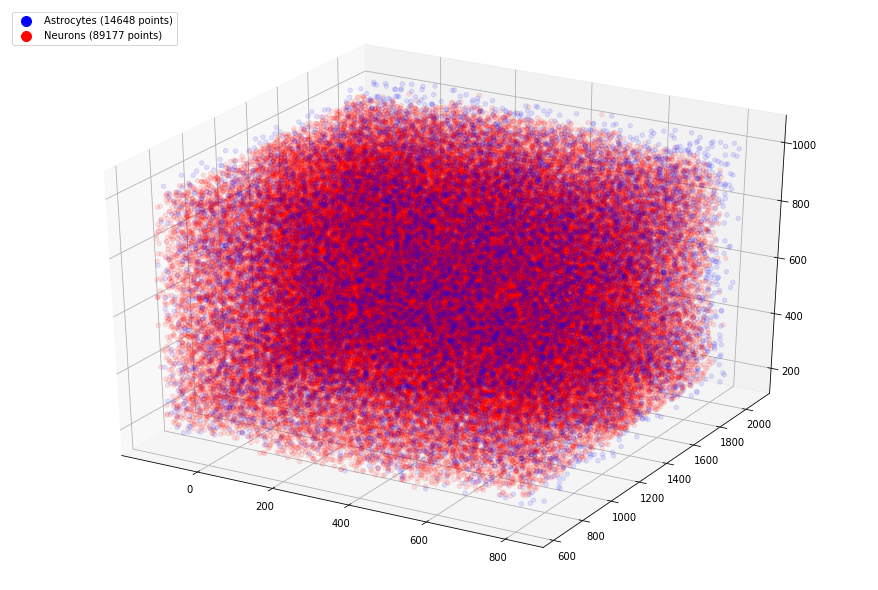

In [3]:
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)
ax.scatter(astro_x, astro_y, astro_z, c='b', alpha=0.1)
ax.scatter(neuro_x, neuro_y, neuro_z, c='r', alpha=0.1)
ax.scatter([], [], s=100, c='b', label='Astrocytes ({} points)'.format(n_astro))
ax.scatter([], [], s=100, c='r', label='Neurons ({} points)'.format(n_neuro))
plt.legend(loc='upper left')
plt.show()

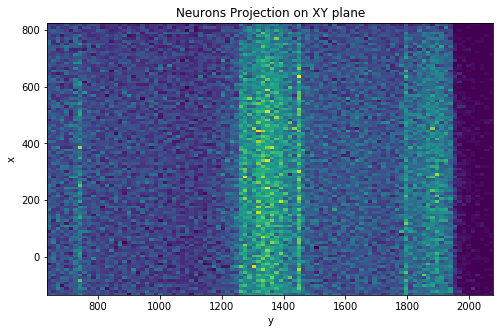

In [4]:
plt.figure(figsize=(8, 5))
plt.hist2d(neuro_y, neuro_x, bins=100)
plt.xlabel('y')
plt.ylabel('x')
plt.title("Neurons Projection on XY plane")
plt.show()

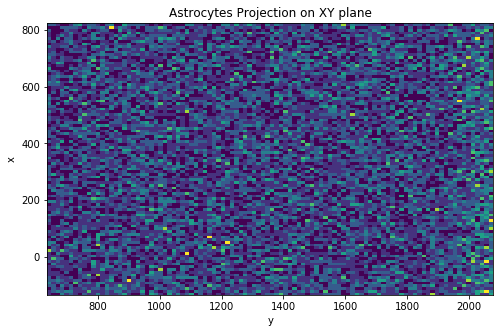

In [5]:
plt.figure(figsize=(8, 5))
plt.hist2d(astro_y, astro_x, bins=100)
plt.xlabel('y')
plt.ylabel('x')
plt.title("Astrocytes Projection on XY plane")
plt.show()

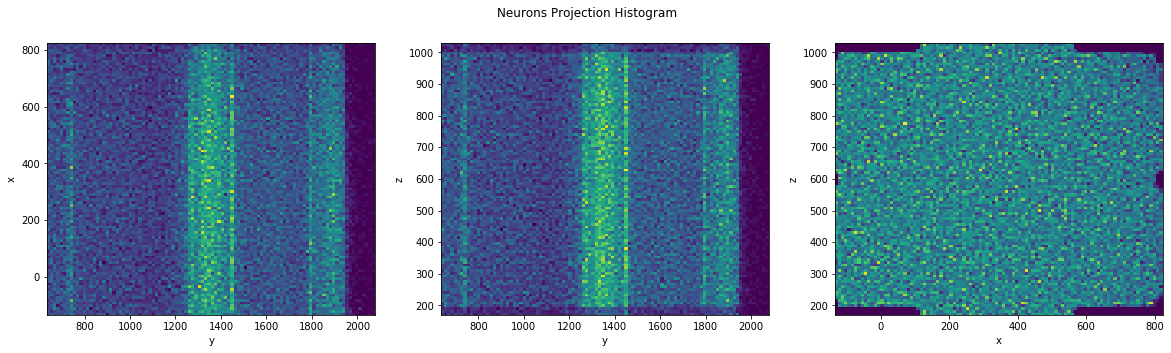

In [6]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.hist2d(neuro_y, neuro_x, bins=100)
plt.xlabel('y')
plt.ylabel('x')
plt.subplot(132)
plt.hist2d(neuro_y, neuro_z, bins=100)
plt.xlabel('y')
plt.ylabel('z')
plt.subplot(133)
plt.hist2d(neuro_x, neuro_z, bins=100)
plt.xlabel('x')
plt.ylabel('z')
plt.suptitle("Neurons Projection Histogram")
plt.show()

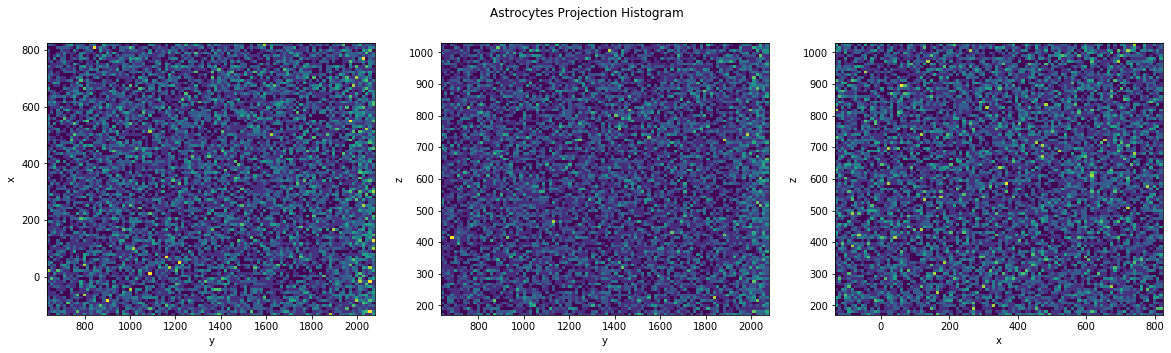

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.hist2d(astro_y, astro_x, bins=100)
plt.xlabel('y')
plt.ylabel('x')
plt.subplot(132)
plt.hist2d(astro_y, astro_z, bins=100)
plt.xlabel('y')
plt.ylabel('z')
plt.subplot(133)
plt.hist2d(astro_x, astro_z, bins=100)
plt.xlabel('x')
plt.ylabel('z')
plt.suptitle("Astrocytes Projection Histogram")
plt.show()

# Traditional Analysis

In [14]:
x_min, x_max = np.min(neuro_x), np.max(neuro_x)
y_min, y_max = np.min(neuro_y), np.max(neuro_y)
z_min, z_max = np.min(neuro_z), np.max(neuro_z)

### Generating Random Uniform data for future comparison

In [15]:

rand_neuro_x = np.random.uniform(x_min, x_max, n_neuro)
rand_neuro_y = np.random.uniform(y_min, y_max, n_neuro)
rand_neuro_z = np.random.uniform(z_min, z_max, n_neuro)
rand_neuro_pos = np.vstack([rand_neuro_x, rand_neuro_y, rand_neuro_z]).T

rand_astro_x = np.random.uniform(x_min, x_max, n_astro)
rand_astro_y = np.random.uniform(y_min, y_max, n_astro)
rand_astro_z = np.random.uniform(z_min, z_max, n_astro)
rand_astro_pos = np.vstack([rand_astro_x, rand_astro_y, rand_astro_z]).T


### Computing KNN statistics

In [17]:
def get_nn_distances(points, k=10):
    """
    Computes a matrix with k-nearest neighbours distances
    Input:
    points: (n x 3) numpy array with coordinates
    k: max number of nearest neighbours
    Returns:
    a (n x k) numpy array with distances
    """
    tree = spatial.KDTree(points)
    distances = np.zeros((points.shape[0], k))
    for i, point in enumerate(points):
        distances[i] = tree.query(point, k=k+1)[0][1:]
    return distances

In [18]:
%%time 
astro_knn_dist = get_nn_distances(astrocytes_pos, 10)
neuro_knn_dist = get_nn_distances(neurons_pos, 10)
rand_astro_knn_dist = get_nn_distances(rand_astro_pos, 10)
rand_neuro_knn_dist = get_nn_distances(rand_neuro_pos, 10)

CPU times: user 2min 20s, sys: 842 ms, total: 2min 21s
Wall time: 2min 27s


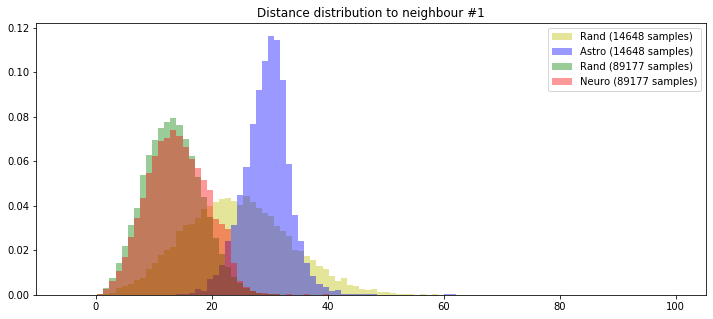

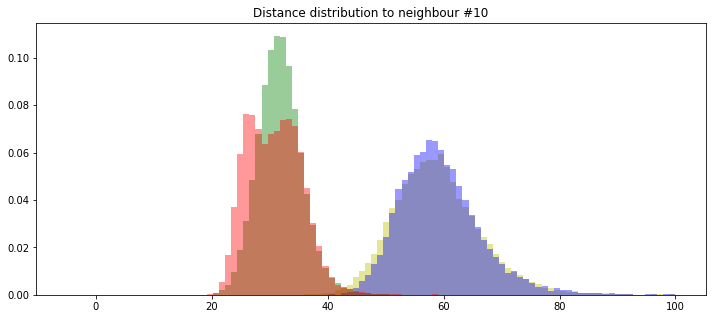

In [19]:
for k in [0, 9]:
    plt.figure(figsize=(12, 5))
    plt.title('Distance distribution to neighbour #{}'.format(k + 1))
    plt.hist(rand_astro_knn_dist[:, k], 
             density=True, 
             range=(-5, 100), 
             alpha=0.4, 
             bins=100, 
             color='y',
             label='Rand ({} samples)'.format(n_astro))    
    plt.hist(astro_knn_dist[:, k], 
             density=True, 
             range=(-5, 100), 
             alpha=0.4, 
             bins=100, 
             color='b',
             label='Astro ({} samples)'.format(n_astro))
    plt.hist(rand_neuro_knn_dist[:, k], 
             density=True, 
             range=(-5, 100), 
             alpha=0.4, 
             bins=100, 
             color='g', 
             label='Rand ({} samples)'.format(n_neuro))

    plt.hist(neuro_knn_dist[:, k], 
             density=True, 
             range=(-5, 100), 
             alpha=0.4, 
             bins=100, 
             color='r', 
             label='Neuro ({} samples)'.format(n_neuro))
    if k == 0:
        plt.legend(loc='upper right')
    plt.show()

### Pair Correlation Function

In [31]:
def pairCorrelationFunction_3D(x, y, z, S, rMax, dr):
    """Compute the three-dimensional pair correlation function for a set of
    spherical particles contained in a cube with side length S.  This simple
    function finds reference particles such that a sphere of radius rMax drawn
    around the particle will fit entirely within the cube, eliminating the need
    to compensate for edge effects.  If no such particles exist, an error is
    returned.  Try a smaller rMax...or write some code to handle edge effects! ;)

    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        z               an array of z positions of centers of particles
        S               length of each side of the cube in space
        rMax            outer diameter of largest spherical shell
        dr              increment for increasing radius of spherical shell

    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        spherical shells used to compute g(r)
        reference_indices   indices of reference particles
    """
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram

    # Find particles which are close enough to the cube center that a sphere of radius
    # rMax will not cross any face of the cube
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    bools5 = z > rMax
    bools6 = z < (S - rMax)

    interior_indices, = where(bools1 * bools2 * bools3 * bools4 * bools5 * bools6)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a sphere of radius rMax\
                will lie entirely within a cube of side length S.  Decrease rMax\
                or increase the size of the cube.")

    edges = arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = zeros([num_interior_particles, num_increments])
    radii = zeros(num_increments)
    numberDensity = len(x) / S**3

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = sqrt((x[index] - x)**2 + (y[index] - y)**2 + (z[index] - z)**2)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, normed=False)
        g[p,:] = result / numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = mean(g[:, i]) / (4.0 / 3.0 * pi * (rOuter**3 - rInner**3))

    return (g_average, radii, interior_indices)
    # Number of particles in shell/total number of particles/volume of shell/number density
    # shell volume = 4/3*pi(r_outer**3-r_inner**3)
####

In [32]:
# Particle setup
domain_size = 900.0

# Calculation setup
dr = 0.5

rMax = domain_size / 15
(g_r, 
 r, 
 reference_indices) = pairCorrelationFunction_3D(astro_x, 
                                                 astro_y, 
                                                 astro_z, 
                                                 domain_size, 
                                                 rMax, 
                                                 dr)
(neuro_g_r, 
 neuro_r, 
 neuro_reference_indices) = pairCorrelationFunction_3D(neuro_x, 
                                                       neuro_y, 
                                                       neuro_z, 
                                                       domain_size, 
                                                       rMax, 
                                                       dr)
(rand_n_g_r, 
 rand_n_r, 
 rand_n_reference_indices) = pairCorrelationFunction_3D(rand_neuro_x, 
                                                        rand_neuro_y, 
                                                        rand_neuro_z, 
                                                        domain_size, 
                                                        rMax, 
                                                        dr)
(rand_a_g_r, 
 rand_a_r, 
 rand_a_reference_indices) = pairCorrelationFunction_3D(rand_astro_x, 
                                                        rand_astro_y, 
                                                        rand_astro_z, 
                                                        domain_size, 
                                                        rMax, 
                                                        dr)

<ipython-input-31-a5677d0cc002>:54: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  (result, bins) = histogram(d, bins=edges, normed=False)


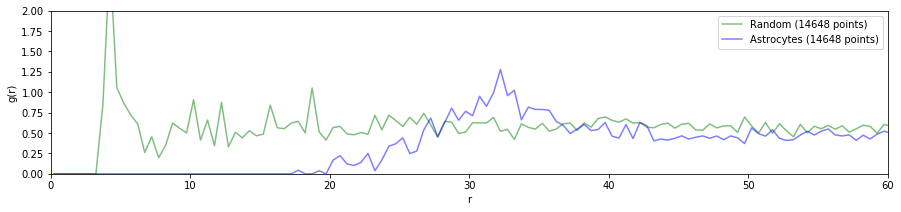

In [33]:
# Visualize
plt.figure(figsize=(15, 3))
plt.plot(rand_a_r, rand_a_g_r, color='green', alpha=0.5, label=f'Random ({n_astro} points)')
plt.plot(r, g_r, color='blue', alpha=0.5, label=f'Astrocytes ({n_astro} points)')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.xlim( (0, rMax) )
plt.ylim((0, 2))
plt.legend(loc='upper right')
plt.show()

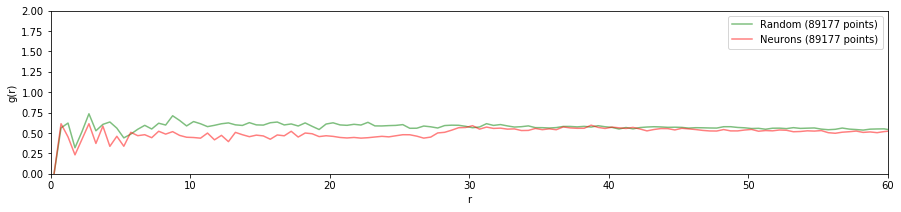

In [34]:
# Visualize
plt.figure(figsize=(15, 3))
plt.plot(rand_n_r, rand_n_g_r, color='green', alpha=0.5, label=f'Random ({n_neuro} points)')
plt.plot(neuro_r, neuro_g_r, color='red', alpha=0.5, label=f'Neurons ({n_neuro} points)')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.xlim( (0, rMax) )
plt.ylim((0, 2))
# plt.ylim( (0, 1.05 * neuro_g_r.max()) )
plt.legend(loc='upper right')
plt.show()

# Applying Topological Data Analysis

### Preliminaries
In order to run this code, please ensure that you have precomputed barcodes for both datasets. You can do it either with ripser (external command-line tool), or with giotto-tda (inside jupyter notebook).

For our case, we used ripser to compute the barcodes and stored them in "../LocalData" folder

In [21]:
def return_barcodes(filename):
    barcodes = []
    with open(filename, 'r') as f:
        cur_dim = -1
        while True:
            line = f.readline()
            if len(line) == 0:
                break
            if line[:28] == "persistence intervals in dim":
                cur_dim += 1
                barcodes.append([])
            elif line[1] == "[":
                start, end = line[2:-2].split(',')
                if end == " ":
                    continue
                barcodes[-1].append((float(start), float(end)))
    return barcodes

In [22]:
good_barcodes_astro = return_barcodes('../LocalData/astro_output_tshd_300_dim_2')
good_barcodes_neuro = return_barcodes('../LocalData/neuro_output_tshd_80_dim_2_new')
good_barcodes_random_astro2 = return_barcodes('../LocalData/rand2_astro_tshd_150')
good_barcodes_random_neuro2 = return_barcodes('../LocalData/rand2_neuro_tshd_75')

In [23]:
def get_points(barcodes):
    x_coords = []
    y_coords = []
    for barcode in barcodes:
        x_coords.append([point[0] for point in barcode])
        y_coords.append([point[1] for point in barcode])
    return x_coords, y_coords

In [24]:
neuro = get_points(good_barcodes_neuro)
astro = get_points(good_barcodes_astro)
rand_neuro2 = get_points(good_barcodes_random_neuro2)
rand_astro2 = get_points(good_barcodes_random_astro2)

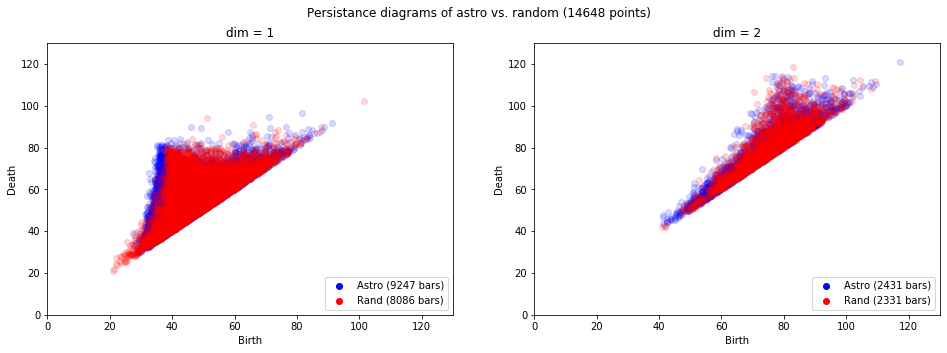

In [29]:
alpha = 0.15
plt.figure(figsize=(16, 5))
plt.suptitle("Persistance diagrams of astro vs. random ({0} points)".format(n_astro))
plt.subplot(121)
plt.scatter(np.array(astro[0][1]), np.array(astro[1][1]), c='b', alpha=alpha)
plt.scatter(np.array(rand_astro2[0][1]), np.array(rand_astro2[1][1]), c='r', alpha=alpha)
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.scatter([], [], c='b', label='Astro ({} bars)'.format(len(astro[0][1])))
plt.scatter([], [], c='r', label='Rand ({} bars)'.format(len(rand_astro2[0][1])))
plt.legend(loc='lower right')
plt.title("dim = 1")
plt.subplot(122)
plt.scatter(np.array(astro[0][2]), np.array(astro[1][2]), c='b', alpha=alpha)
plt.scatter(np.array(rand_astro2[0][2]), np.array(rand_astro2[1][2]), c='r', alpha=alpha)
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.scatter([], [], c='b', label='Astro ({} bars)'.format(len(astro[0][2])))
plt.scatter([], [], c='r', label='Rand ({} bars)'.format(len(rand_astro2[0][2])))
plt.title("dim = 2")
plt.legend(loc='lower right')
# plt.savefig("astro_rand_pers_diag_full.pdf")
plt.show()

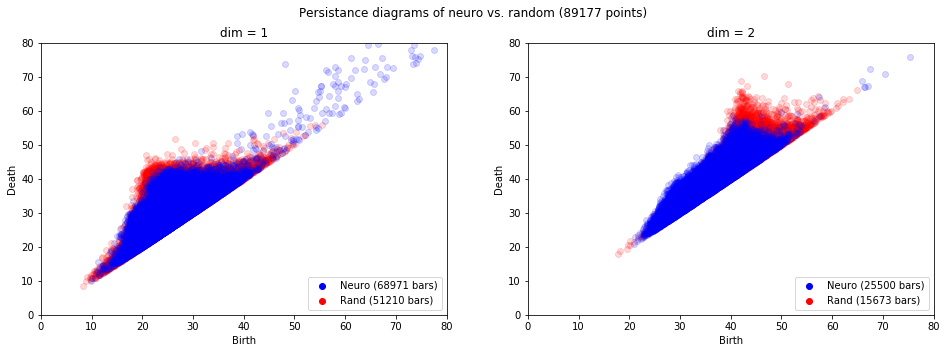

In [30]:
plt.figure(figsize=(16, 5))
plt.suptitle("Persistance diagrams of neuro vs. random ({0} points)".format(n_neuro))
plt.subplot(121)
plt.scatter(np.array(rand_neuro2[0][1]), np.array(rand_neuro2[1][1]), c='r', alpha=alpha)
plt.scatter(np.array(neuro[0][1]), np.array(neuro[1][1]), c='b', alpha=alpha)
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.scatter([], [], c='b', label='Neuro ({} bars)'.format(len(neuro[0][1])))
plt.scatter([], [], c='r', label='Rand ({} bars)'.format(len(rand_neuro2[0][1])))
plt.title("dim = 1")
plt.legend(loc='lower right')
plt.subplot(122)
plt.scatter(np.array(rand_neuro2[0][2]), np.array(rand_neuro2[1][2]), c='r', alpha=alpha)
plt.scatter(np.array(neuro[0][2]), np.array(neuro[1][2]), c='b', alpha=alpha)
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.scatter([], [], c='b', label='Neuro ({} bars)'.format(len(neuro[0][2])))
plt.scatter([], [], c='r', label='Rand ({} bars)'.format(len(rand_neuro2[0][2])))
plt.title("dim = 2")
plt.legend(loc='lower right')
plt.show()